# Dog Breed Classification
Luca Arrotta

## 1. Dataset management

### Dataset import
Loading images and labels.

In [1]:
from sklearn.datasets import load_files
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os

data = load_files("../MyDataset/Images")
dog_files = np.array(data['filenames'])
dog_targets = np.array(data['target'])
dog_names = [item[10:] for item in os.listdir("../MyDataset/Images")]

Using TensorFlow backend.


In [2]:
import cv2
import pandas as pd
from tqdm import tqdm

targets_series = pd.Series(dog_targets)
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

im_size = 200
x_train = []
y_train = []
x_test = []
i = 0 

for el in tqdm(dog_files):
    img = cv2.imread(el)
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1


y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32) / 255.

print(x_train.shape)
print(y_train.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 6542/6542 [01:22<00:00, 79.10it/s]


(6542, 200, 200, 3)
(6542, 30)


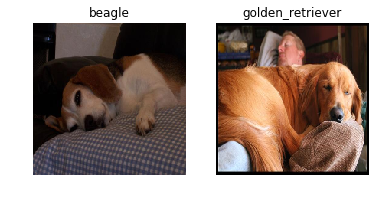

In [3]:
dog1 = 0
dog2 = 3

plt.subplot(1, 2, 1)
plt.title(dog_names[np.where(y_train[dog1]==1)[0][0]])
plt.axis('off')
plt.imshow(x_train[dog1][:,:,::-1])
plt.subplot(1, 2, 2)
plt.title(dog_names[np.where(y_train[dog2]==1)[0][0]])
plt.axis('off')
plt.imshow(x_train[dog2][:,:,::-1])
plt.show()

### Split Dataset in Training set, Test set and Validation set

- Training set:   80%
- Test set:       10%
- Validation set: 10%

In [4]:
# unbalanced split
'''
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)
'''

# balanced split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=0, stratify=y_test)

<br>

## 2. CNN implementation

### Convolutional Neural Network architecture

In [5]:
import keras
from keras import layers
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.models import Model
from keras import regularizers


input_shape=(200, 200, 3)
nClasses = 30

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(nClasses, activation='softmax'))


print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 200, 200, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 198, 198, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 196, 196, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 194, 194, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 97, 64)        0         
__________

## 3. Training

### Data Augmentation

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.2,   # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    rotation_range=15,  
    shear_range=0.05,      
    horizontal_flip=True)  

# fit augmented image generator on data
datagen.fit(x_train)

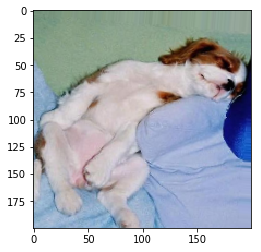

In [7]:
# image obtained with data augmentation
augmented_images, a = next( datagen.flow( x_train, y_train, batch_size=4*4))
plt.imshow(augmented_images[0][:,:,::-1])
plt.show()

In [8]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

### Training: first stage

In [9]:
epochs = 50
batch_size = 4

### Using Image Augmentation
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val), 
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=2)  # verbose=1 per avere più dettagli

Epoch 1/50
 - 338s - loss: 3.4703 - acc: 0.0757 - val_loss: 3.6572 - val_acc: 0.0992

Epoch 00001: val_loss improved from inf to 3.65723, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 2/50
 - 324s - loss: 3.2886 - acc: 0.0935 - val_loss: 3.5259 - val_acc: 0.1160

Epoch 00002: val_loss improved from 3.65723 to 3.52589, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 3/50
 - 324s - loss: 3.2092 - acc: 0.1107 - val_loss: 3.0371 - val_acc: 0.1618

Epoch 00003: val_loss improved from 3.52589 to 3.03714, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 4/50
 - 324s - loss: 3.1286 - acc: 0.1237 - val_loss: 3.3815 - val_acc: 0.1527

Epoch 00004: val_loss did not improve from 3.03714
Epoch 5/50
 - 324s - loss: 3.0545 - acc: 0.1405 - val_loss: 2.9106 - val_acc: 0.1649

Epoch 00005: val_loss improved from 3.03714 to 2.91058, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 6/50
 - 325s - lo

In [10]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

In [11]:
'''
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_test]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(y_test, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
'''

score = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %.4f%%" % (score[1]*100))

Test accuracy: 54.7401%


Text(0.5,1,'Accuracy Curves\n(Batch_Size: 4)')

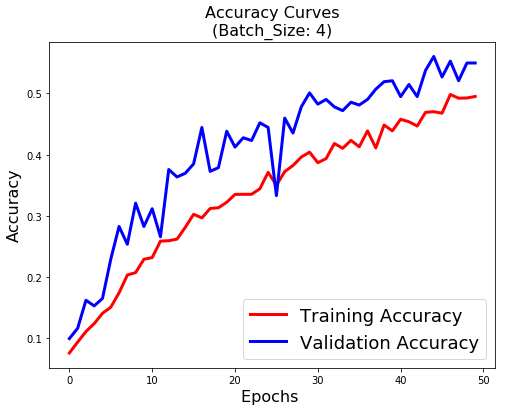

In [12]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves\n(Batch_Size: {})'.format(batch_size),fontsize=16)

Text(0.5,1,'Loss Curves\n(Batch_Size: 4)')

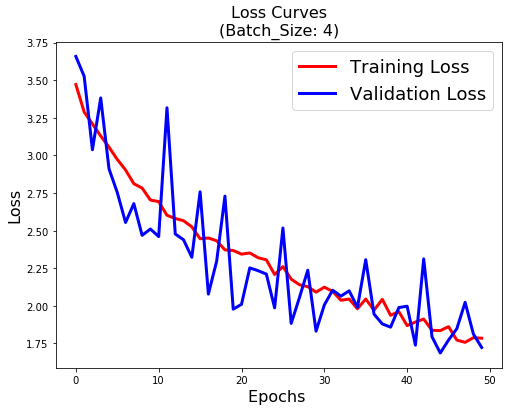

In [13]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves\n(Batch_Size: {})'.format(batch_size),fontsize=16)

### Training: second stage

In [14]:
epochs = 10
batch_size = 8

### Using Image Augmentation
history2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val), 
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=2)

Epoch 1/10
 - 286s - loss: 1.4745 - acc: 0.5659 - val_loss: 1.5604 - val_acc: 0.5786

Epoch 00001: val_loss improved from 1.68622 to 1.56040, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 2/10
 - 281s - loss: 1.3960 - acc: 0.5940 - val_loss: 1.5404 - val_acc: 0.5878

Epoch 00002: val_loss improved from 1.56040 to 1.54039, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 3/10
 - 281s - loss: 1.4092 - acc: 0.5860 - val_loss: 1.4591 - val_acc: 0.5878

Epoch 00003: val_loss improved from 1.54039 to 1.45909, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 4/10
 - 281s - loss: 1.3783 - acc: 0.6009 - val_loss: 1.3827 - val_acc: 0.5893

Epoch 00004: val_loss improved from 1.45909 to 1.38267, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 5/10
 - 281s - loss: 1.3540 - acc: 0.6007 - val_loss: 1.3642 - val_acc: 0.6000

Epoch 00005: val_loss improved from 1.38267 to 1.36421, saving model t

In [15]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %.4f%%" % (score[1]*100))

Test accuracy: 61.4679%


Text(0.5,1,'Loss Curves\n(Batch_Size: 8)')

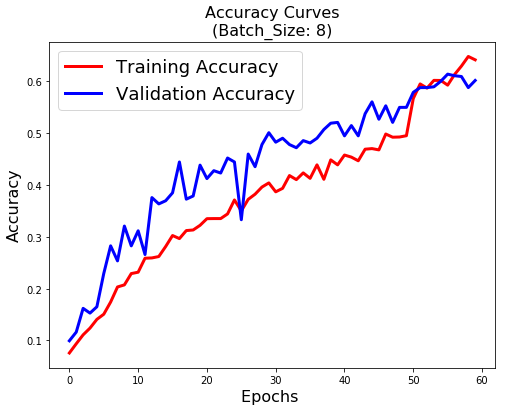

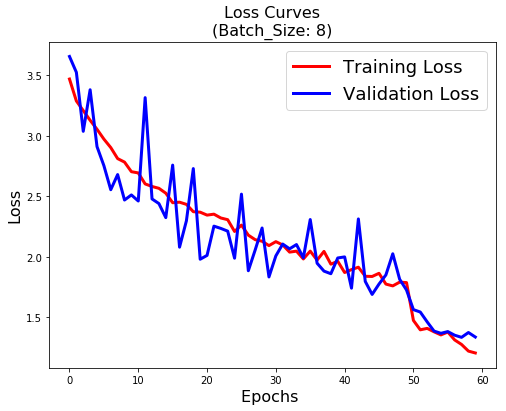

In [17]:
prova1_acc = history.history['acc'] + history2.history['acc']
prova1_val_acc = history.history['val_acc'] + history2.history['val_acc']

plt.figure(figsize=[8,6])
plt.plot(prova1_acc,'r',linewidth=3.0)
plt.plot(prova1_val_acc,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves\n(Batch_Size: {})'.format(batch_size),fontsize=16)


prova1_loss = history.history['loss'] + history2.history['loss']
prova1_val_loss = history.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=[8,6])
plt.plot(prova1_loss,'r',linewidth=3.0)
plt.plot(prova1_val_loss,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves\n(Batch_Size: {})'.format(batch_size),fontsize=16)

### Training: third stage

In [ ]:
epochs = 10
batch_size = 16

### Using Image Augmentation
history3 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val), 
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=2)

Epoch 1/10
 - 254s - loss: 1.0477 - acc: 0.6850 - val_loss: 1.2541 - val_acc: 0.6366

Epoch 00001: val_loss improved from 1.33080 to 1.25410, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 2/10


In [ ]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %.4f%%" % (score[1]*100))

In [ ]:
prova1_acc = history.history['acc'] + history2.history['acc'] + history3.history['acc']
prova1_val_acc = history.history['val_acc'] + history2.history['val_acc'] + history3.history['val_acc']

plt.figure(figsize=[8,6])
plt.plot(prova1_acc,'r',linewidth=3.0)
plt.plot(prova1_val_acc,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves\n(Batch_Size: {})'.format(batch_size),fontsize=16)


prova1_loss = history.history['loss'] + history2.history['loss'] + history3.history['loss']
prova1_val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss']

plt.figure(figsize=[8,6])
plt.plot(prova1_loss,'r',linewidth=3.0)
plt.plot(prova1_val_loss,'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves\n(Batch_Size: {})'.format(batch_size),fontsize=16)

In [ ]:
import random

n=len(x_test)
plt.figure(figsize=(16, 8))
for i in range(8):
    random_index = random.randint(0, n-1)
    idx = np.argmax(model.predict(np.expand_dims(x_test[random_index], axis=0)))
    plt.subplot(2, 4, i+1)
    plt.imshow(x_test[random_index][:,:,::-1])
    color = 'b'
    if idx == np.argmax(y_test[random_index]):
        color = 'g'
    else:
        color = 'r'
    plt.title("{0} ({1})".format(dog_names[idx], dog_names[np.argmax(y_test[random_index])]), color = color)
    plt.axis('off')

## 4. Save the current Dataset

Useful if we want to try different parameters with the same splitting.

In [23]:
#'''
for el in dog_names:
    newpath = "../SavedDataset/Train/{}".format(el)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    newpath = "../SavedDataset/Val/{}".format(el)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    newpath = "../SavedDataset/Test/{}".format(el)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
#'''

In [24]:
#'''
from PIL import Image
j = 0
for i in range(len(x_train)):
    result = Image.fromarray((x_train[i] * 255).astype(np.uint8))
    b, g, r = result.split()
    result = Image.merge("RGB", (r, g, b))
    folder = "../SavedDataset/Train/{}".format(dog_names[np.argmax(y_train[i])])
    name = "trainImage{}".format(j)
    j+=1
    result.save("{0}/{1}.jpg".format(folder, name))
    
j = 0
for i in range(len(x_val)):
    result = Image.fromarray((x_val[i] * 255).astype(np.uint8))
    b, g, r = result.split()
    result = Image.merge("RGB", (r, g, b))
    folder = "../SavedDataset/Val/{}".format(dog_names[np.argmax(y_val[i])])
    name = "valImage{}".format(j)
    j+=1
    result.save("{0}/{1}.jpg".format(folder, name))
    
j = 0
for i in range(len(x_test)):
    result = Image.fromarray((x_test[i] * 255).astype(np.uint8))
    b, g, r = result.split()
    result = Image.merge("RGB", (r, g, b))
    folder = "../SavedDataset/Test/{}".format(dog_names[np.argmax(y_test[i])])
    name = "testImage{}".format(j)
    j+=1
    result.save("{0}/{1}.jpg".format(folder, name))
#'''

## 5. Save the model

### Save the current model

In [25]:
'''
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
'''

'\n# serialize model to JSON\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model.h5")\nprint("Saved model to disk")\n'

In [26]:
score = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 77.68%


In [27]:
from keras.models import load_model

model.save('my_model_77.68%.h5')  # creates a HDF5 file 'my_model.h5'

### Load a model 

In [30]:
from keras.models import load_model
model = load_model('../ModelloMigliore/my_model_77.68%.h5')
model.load_weights("../ModelloMigliore/weights.bestaugmented.from_scratch_77.68%.hdf5")

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:.4f}%'.format(100*score[1]))

Test accuracy: 77.6758%


## 6. Export

Export the model in a format usable in Android applications.

In [32]:
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from keras import backend as K

folder = 'modello_77.68%'
MODEL_NAME = 'modello_di_prova'

def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, folder, \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), folder + '/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph(folder + '/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, folder + '/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        folder + '/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open(folder + '/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile(folder + '/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

In [33]:
export_model(tf.train.Saver(), model, ["batch_normalization_1_input"], "dense_1/Softmax")

INFO:tensorflow:Restoring parameters from modello_77.68%/modello_di_prova.chkp
INFO:tensorflow:Froze 54 variables.
INFO:tensorflow:Converted 54 variables to const ops.
graph saved!
